In [ ]:
!mkdir ../dataset 
!wget -O ../dataset/KDDTrain+.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTrain%2B.txt
!wget -O ../dataset/KDDTest+.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTest%2B.txt
!wget -O ../dataset/KDDTrain+_20Percent.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTrain%2B_20Percent.txt
!wget -O ../dataset/KDDTest-21.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTest-21.txt

mkdir: cannot create directory ‘../dataset’: File exists
--2022-04-05 21:01:11--  https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTrain%2B.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19109424 (18M) [text/plain]
Saving to: ‘../dataset/KDDTrain+.txt’

../dataset/KDDTrain 100%[===================>]  18.22M  --.-KB/s    in 0.1s    

2022-04-05 21:01:12 (172 MB/s) - ‘../dataset/KDDTrain+.txt’ saved [19109424/19109424]

--2022-04-05 21:01:12--  https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTest%2B.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|1

In [ ]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
plt.style.use('grayscale')
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold as KFold
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn import preprocessing

In [ ]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class Critic(nn.Module):
  def __init__(self, data_dim):
    super().__init__()
    self.disc = nn.Sequential(
        nn.Conv1d(1,3,kernel_size=(1,3),stride=1),
        nn.BatchNorm2d(3),
        nn.ReLU(),
        nn.Conv1d(3,3,kernel_size=(1,3),stride=1),
        nn.BatchNorm2d(3),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(111, data_dim),
    )

  def forward(self, x):
    return self.disc(x)


class Generator(nn.Module):
  def __init__(self, z_dim, data_dim):
    super().__init__()
    self.gen = nn.Sequential(
        nn.Conv1d(1,3,kernel_size=(1,3),stride=1),
        nn.BatchNorm2d(3),
        nn.ReLU(),
        nn.Conv1d(3,3,kernel_size=(1,3),stride=1),
        nn.BatchNorm2d(3),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(288, data_dim),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.gen(x)

In [ ]:
def visualize_synthetic_data(generated, original, title):
  generated = generated[:41]
  original = original.iloc[:,:41][:41]

  fig, (original_ax, synthesized_ax) = plt.subplots(1,2,figsize=(12,12))
  original_ax.set_title(f'Original({title})')
  synthesized_ax.set_title(f'Synthetic({title})')
  _ = original_ax.imshow(original)
  _ = synthesized_ax.imshow(generated)

In [ ]:
def generate_data(generator, num_instances, z_dim):
  generator.eval()
  with torch.no_grad():
    out = generator(torch.randn(num_instances, z_dim).view(-1,1,1,z_dim))
    return out.detach()

In [ ]:
def train_gan(pt_train, data_dim, z_dim, epochs, lr, critic_iter, weight_clip):

  critic = Critic(data_dim).to(device)
  gen = Generator(z_dim, data_dim).to(device)
  opt_critic = torch.optim.RMSprop(critic.parameters(), lr = lr)
  opt_gen = torch.optim.RMSprop(gen.parameters(), lr = lr)

  losses_Gen = []
  losses_Critic = []

  for epoch in range(epochs):
    for batch_idx, (real,_) in enumerate(pt_train):
      #Train Discriminator: maximing function

      for _ in range(critic_iter):
        noise = torch.randn(pt_train.batch_size, z_dim)
        fake = gen(noise.view(-1,1,1,z_dim))
        critic_real = critic(real.view(-1,1,1,data_dim)).view(-1)
        critic_fake = critic(fake.view(-1,1,1,data_dim)).view(-1)
        loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
        critic.zero_grad()
        loss_critic.backward(retain_graph = True)
        opt_critic.step()
        for p in critic.parameters():
          p.data.clamp_(-weight_clip, weight_clip)

      output = critic(fake.view(-1,1,1,data_dim)).view(-1)
      loss_gen = -torch.mean(output)
      gen.zero_grad()
      loss_gen.backward()
      opt_gen.step()
      
      if batch_idx == 0:
        print(
            f"Epoch [{epoch+1}/{epochs}] \ "
            f"Loss C:{loss_critic:.4f} | Loss G:{loss_gen:.4f}"
        ) 
    losses_Critic.append(loss_critic.item())
    losses_Gen.append(loss_gen.item())

  return gen, losses_Gen, losses_Critic

In [ ]:
def create_dataloader(X, y, batch_size):
  if y:
    y = np.array(X['41'])
  else:
    y = torch.ones(size=(X.shape[0],))
  y = torch.tensor(y, dtype=torch.float).to(device)

  X = np.array(X.iloc[:,:-1])
  X = torch.tensor(X, dtype=torch.float).to(device)

  pt_train = TensorDataset(X,y)
  pt_train = DataLoader(pt_train, batch_size=batch_size)
  return pt_train

In [ ]:
def normalize_data(X):
  mms = MinMaxScaler()
  return mms.fit_transform(X)

In [ ]:
def visualize_train_loss(loss_1, labels, epochs, loss_2 = None):
  plt.figure(figsize=(10,4))
  plt.plot(loss_1, linewidth=2)
  if loss_2:
    plt.plot(loss_2, linewidth=2)
  plt.legend(labels)
  plt.ylabel("loss")
  _ = plt.xlabel(f"epochs ({epochs})")

## Preprocessing

In [ ]:
df=pd.read_csv('../dataset/KDDTrain+.txt', header=None)
df2=pd.read_csv('../dataset/KDDTest+.txt', header=None)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [ ]:
df.columns = [str(i) for i in range(0, len(df.columns))]
df2.columns = [str(i) for i in range(0, len(df2.columns))]

In [ ]:
# Replacing Null values with 0. ML classifer cannot learn on Null values
df.fillna(0, inplace=True)
df2.fillna(0, inplace=True)

In [ ]:
# Peak on dataset
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [ ]:
df.shape

(125973, 43)

In [ ]:
# Peak on the dataset
df.drop('42',axis=1, inplace=True)
df2.drop('42',axis=1, inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
sub_classes = df.iloc[:,41].value_counts()

In [ ]:
print(sub_classes)

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: 41, dtype: int64


In [ ]:
r2l = ['ftp_write','guess_passwd', 'imap', 'multihop', 'phf', 'spy','warezclient','warezmaster','xlock', 'xsnoop','named',
       'sendmail','snmpgetattack', 'snmpguess','httptunnel']
u2r = ['buffer_overflow', 'loadmodule','perl','ps','rootkit','sqlattack','xterm']
dos = ['back', 'land', 'neptune', 'smurf', 'teardrop','pod','mailbomb', 'processtable','udpstorm', 'worm','apache2']
probe = ['ipsweep', 'nmap', 'portsweep', 'satan','saint','mscan']
normal = ['normal']

In [ ]:
pd.set_option('display.max_rows', None) # or 1000.
train_1 = df['1'].value_counts()
train_1.rename('Train', inplace=True)
test_1 = df2['1'].value_counts()
test_1.rename('Test', inplace=True)
cnct = pd.concat([train_1, test_1], axis = 1)
cnct

,Train,Test
tcp,102689,18880
udp,14993,2621
icmp,8291,1043


In [ ]:
train_2 = df['2'].value_counts()
train_2.rename('Train', inplace=True)
test_2 = df2['2'].value_counts()
test_2.rename('Test', inplace=True)
cnct = pd.concat([train_2, test_2], axis = 1)
cnct

,Train,Test
http,40338,7853.0
private,21853,4774.0
domain_u,9043,894.0
smtp,7313,934.0
ftp_data,6860,851.0
eco_i,4586,262.0
other,4359,838.0
ecr_i,3077,752.0
telnet,2353,1626.0
finger,1767,136.0


In [ ]:
train_3 = df['3'].value_counts()
train_3.rename('Train', inplace=True)
test_3 = df2['3'].value_counts()
test_3.rename('Test', inplace=True)
cnct = pd.concat([train_3, test_3], axis = 1)
cnct

,Train,Test
SF,74945,14875
S0,34851,2013
REJ,11233,3850
RSTR,2421,669
RSTO,1562,773
S1,365,21
SH,271,73
S2,127,15
RSTOS0,103,2
S3,49,249


In [ ]:
df_X = df.drop('41', axis=1)
le = LabelEncoder()
for i in df_X:
  if df_X[i].dtype=='object':
    le.fit(df_X[i])
    df_X[i] = le.transform(df_X[i])
    df2[i] = le.transform(df2[i])
df.iloc[:,:40] = df_X

In [ ]:
df.iloc[:,:40] = normalize_data(df.iloc[:,:40])
df2.iloc[:,:40] = normalize_data(df2.iloc[:,:40])

In [ ]:
u2r_attacks = df[df['41'].apply(lambda x: x in u2r)].copy()
r2l_attacks = df[df['41'].apply(lambda x: x in r2l)].copy()
dos_attacks = df[df['41'].apply(lambda x: x in dos)].copy()
probe_attacks = df[df['41'].apply(lambda x: x in probe)].copy()
normal_traffic = df[df['41'].apply(lambda x: x in normal)].copy()

df['41'] = df['41'].map(
    lambda x: 'malicious' if x in r2l 
    else 'malicious' if x in u2r 
    else 'malicious' if x in dos 
    else 'malicious' if x in probe 
    else 'normal' if x is 'normal'
    else x
    )

df2['41'] = df2['41'].map(
    lambda x: 'malicious' if x in r2l 
    else 'malicious' if x in u2r 
    else 'malicious' if x in dos 
    else 'malicious' if x in probe 
    else 'normal' if x is 'normal'
    else x
    )

### Training set value counts

In [ ]:
df['41'].value_counts()

normal       67343
malicious    58630
Name: 41, dtype: int64

In [ ]:
n,m = df['41'].value_counts()
print(df['41'].value_counts())

normal       67343
malicious    58630
Name: 41, dtype: int64


In [ ]:
imbalance = abs(n-m)
print(f"Imbalance: {imbalance}")

Imbalance: 8713


In [ ]:
print(df['41'].value_counts())

normal       67343
malicious    58630
Name: 41, dtype: int64


### Testing set value counts

In [ ]:
print(df2['41'].value_counts())

malicious    12833
normal        9711
Name: 41, dtype: int64


In [ ]:
df_Y = le.fit(df['41']).transform(df['41'])
df.iloc[:,41] = df_Y
df_Y = le.transform(df2['41'])
df2.iloc[:,41] = df_Y

X_train = df.drop(['41'],axis=1)
y_train = df['41']

X_test = df2.drop(['41'],axis=1)
y_test = df2['41']
X_test = torch.tensor(np.array(X_test), dtype=torch.float)

**Creating TensorDatasets**

In [ ]:
r2l_dataset = create_dataloader(r2l_attacks, None, batch_size = 64)
u2r_dataset = create_dataloader(u2r_attacks, None, batch_size = 8)
dos_dataset = create_dataloader(dos_attacks, None, batch_size = 64)
probe_dataset = create_dataloader(probe_attacks, None, batch_size = 64)
normal_dataset = create_dataloader(normal_traffic, None, batch_size = 64)

**Training GANs**

-------------------------------
Training GAN for R2L attacks
-------------------------------
Epoch [1/250] \ Loss C:-0.0000 | Loss G:-0.0005
Epoch [2/250] \ Loss C:-0.0000 | Loss G:-0.0004
Epoch [3/250] \ Loss C:-0.0000 | Loss G:-0.0003
Epoch [4/250] \ Loss C:-0.0000 | Loss G:-0.0002
Epoch [5/250] \ Loss C:-0.0000 | Loss G:-0.0002
Epoch [6/250] \ Loss C:-0.0000 | Loss G:-0.0001
Epoch [7/250] \ Loss C:-0.0000 | Loss G:-0.0000
Epoch [8/250] \ Loss C:-0.0000 | Loss G:0.0000
Epoch [9/250] \ Loss C:-0.0000 | Loss G:0.0001
Epoch [10/250] \ Loss C:-0.0000 | Loss G:0.0002
Epoch [11/250] \ Loss C:-0.0001 | Loss G:0.0002
Epoch [12/250] \ Loss C:-0.0001 | Loss G:0.0002
Epoch [13/250] \ Loss C:-0.0001 | Loss G:0.0002
Epoch [14/250] \ Loss C:-0.0001 | Loss G:0.0002
Epoch [15/250] \ Loss C:-0.0001 | Loss G:0.0002
Epoch [16/250] \ Loss C:-0.0001 | Loss G:0.0003
Epoch [17/250] \ Loss C:-0.0001 | Loss G:0.0003
Epoch [18/250] \ Loss C:-0.0001 | Loss G:0.0004
Epoch [19/250] \ Loss C:-0.0001 | Loss G:0.00

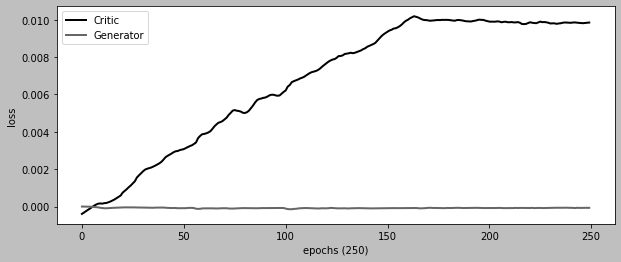

In [ ]:
print('-------------------------------')
print('Training GAN for R2L attacks')
print('-------------------------------')
epochs = 250
r2l_generator, l1, l2 = train_gan(pt_train=r2l_dataset, data_dim=41, z_dim=100, epochs=epochs, lr=5e-5, critic_iter=5, weight_clip=0.01)
visualize_train_loss(l1, labels=['Critic', 'Generator'], epochs = epochs, loss_2 = l2)

-------------------------------
Training GAN for U2R attacks
-------------------------------
Epoch [1/150] \ Loss C:-0.0000 | Loss G:-0.0003
Epoch [2/150] \ Loss C:0.0000 | Loss G:-0.0003
Epoch [3/150] \ Loss C:0.0000 | Loss G:-0.0003
Epoch [4/150] \ Loss C:0.0000 | Loss G:-0.0003
Epoch [5/150] \ Loss C:0.0000 | Loss G:-0.0003
Epoch [6/150] \ Loss C:0.0000 | Loss G:-0.0003
Epoch [7/150] \ Loss C:0.0000 | Loss G:-0.0003
Epoch [8/150] \ Loss C:0.0000 | Loss G:-0.0003
Epoch [9/150] \ Loss C:0.0000 | Loss G:-0.0003
Epoch [10/150] \ Loss C:0.0000 | Loss G:-0.0003
Epoch [11/150] \ Loss C:0.0000 | Loss G:-0.0003
Epoch [12/150] \ Loss C:0.0000 | Loss G:-0.0003
Epoch [13/150] \ Loss C:0.0000 | Loss G:-0.0003
Epoch [14/150] \ Loss C:0.0000 | Loss G:-0.0003
Epoch [15/150] \ Loss C:0.0000 | Loss G:-0.0003
Epoch [16/150] \ Loss C:-0.0000 | Loss G:-0.0003
Epoch [17/150] \ Loss C:-0.0000 | Loss G:-0.0003
Epoch [18/150] \ Loss C:-0.0000 | Loss G:-0.0003
Epoch [19/150] \ Loss C:-0.0000 | Loss G:-0.0003

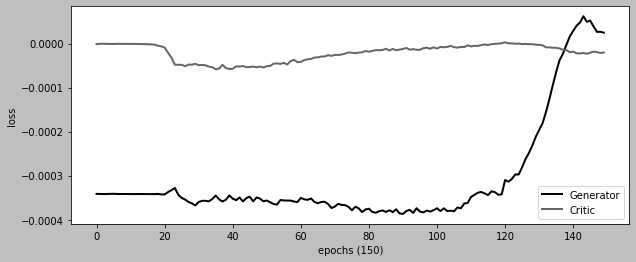

In [ ]:
print('-------------------------------')
print('Training GAN for U2R attacks')
print('-------------------------------')
epochs = 150
u2r_generator,l1, l2 = train_gan(pt_train=u2r_dataset, data_dim=41, z_dim=100, epochs=epochs, lr=5e-5, critic_iter=5, weight_clip=0.01)
visualize_train_loss(l1, labels=['Generator', 'Critic'], epochs=epochs, loss_2 = l2)

-------------------------------
Training GAN for DOS attacks
-------------------------------
Epoch [1/15] \ Loss C:-0.0000 | Loss G:0.0011
Epoch [2/15] \ Loss C:-0.0001 | Loss G:0.0012
Epoch [3/15] \ Loss C:-0.0001 | Loss G:0.0012
Epoch [4/15] \ Loss C:-0.0001 | Loss G:0.0012
Epoch [5/15] \ Loss C:-0.0001 | Loss G:0.0009
Epoch [6/15] \ Loss C:-0.0000 | Loss G:0.0016
Epoch [7/15] \ Loss C:-0.0001 | Loss G:0.0015
Epoch [8/15] \ Loss C:-0.0001 | Loss G:0.0018
Epoch [9/15] \ Loss C:-0.0001 | Loss G:0.0017
Epoch [10/15] \ Loss C:-0.0000 | Loss G:0.0014
Epoch [11/15] \ Loss C:-0.0001 | Loss G:0.0018
Epoch [12/15] \ Loss C:-0.0000 | Loss G:0.0017
Epoch [13/15] \ Loss C:-0.0000 | Loss G:0.0016
Epoch [14/15] \ Loss C:-0.0000 | Loss G:0.0017
Epoch [15/15] \ Loss C:-0.0000 | Loss G:0.0015


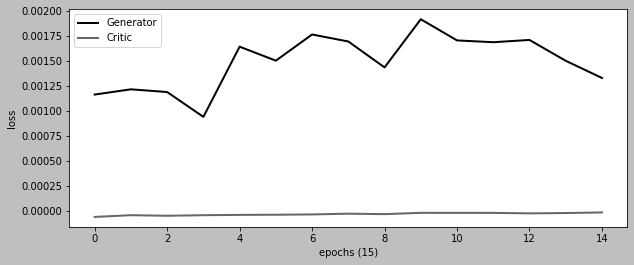

In [ ]:
print('-------------------------------')
print('Training GAN for DOS attacks')
print('-------------------------------')
epochs = 15
dos_generator,l1, l2 = train_gan(pt_train=dos_dataset, data_dim=41, z_dim=100, epochs=epochs, lr=5e-5, critic_iter=5, weight_clip=0.01)
visualize_train_loss(l1, labels=['Generator', 'Critic'], epochs=epochs, loss_2 = l2)

-------------------------------
Training GAN for Probe attacks
-------------------------------
Epoch [1/20] \ Loss C:-0.0000 | Loss G:0.0007
Epoch [2/20] \ Loss C:-0.0000 | Loss G:0.0007
Epoch [3/20] \ Loss C:-0.0001 | Loss G:0.0008
Epoch [4/20] \ Loss C:-0.0001 | Loss G:0.0008
Epoch [5/20] \ Loss C:-0.0001 | Loss G:0.0009
Epoch [6/20] \ Loss C:-0.0001 | Loss G:0.0009
Epoch [7/20] \ Loss C:-0.0001 | Loss G:0.0008
Epoch [8/20] \ Loss C:-0.0001 | Loss G:0.0010
Epoch [9/20] \ Loss C:-0.0001 | Loss G:0.0011
Epoch [10/20] \ Loss C:-0.0002 | Loss G:0.0008
Epoch [11/20] \ Loss C:-0.0002 | Loss G:0.0011
Epoch [12/20] \ Loss C:-0.0001 | Loss G:0.0009
Epoch [13/20] \ Loss C:-0.0002 | Loss G:0.0010
Epoch [14/20] \ Loss C:-0.0001 | Loss G:0.0012
Epoch [15/20] \ Loss C:-0.0002 | Loss G:0.0017
Epoch [16/20] \ Loss C:-0.0001 | Loss G:0.0003
Epoch [17/20] \ Loss C:-0.0003 | Loss G:-0.0009
Epoch [18/20] \ Loss C:-0.0003 | Loss G:-0.0005
Epoch [19/20] \ Loss C:-0.0001 | Loss G:-0.0002
Epoch [20/20] \ Lo

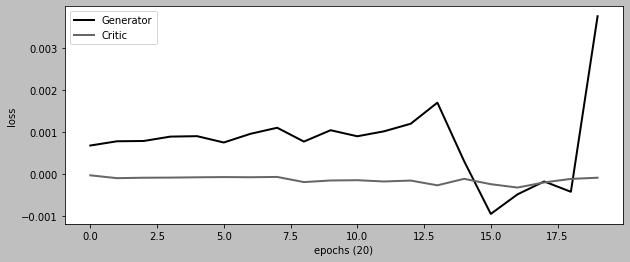

In [ ]:
print('-------------------------------')
print('Training GAN for Probe attacks')
print('-------------------------------')
epochs = 20
probe_generator,l1, l2 = train_gan(pt_train=probe_dataset, data_dim=41, z_dim=100, epochs=epochs, lr=5e-5, critic_iter=5, weight_clip=0.01)
visualize_train_loss(l1, labels=['Generator', 'Critic'], epochs=epochs, loss_2=l2)

-------------------------------
Training GAN for Normal traffic
-------------------------------
Epoch [1/15] \ Loss C:-0.0000 | Loss G:-0.0003
Epoch [2/15] \ Loss C:-0.0001 | Loss G:-0.0005
Epoch [3/15] \ Loss C:-0.0001 | Loss G:-0.0008
Epoch [4/15] \ Loss C:-0.0000 | Loss G:-0.0005
Epoch [5/15] \ Loss C:-0.0000 | Loss G:-0.0006
Epoch [6/15] \ Loss C:-0.0000 | Loss G:-0.0006
Epoch [7/15] \ Loss C:-0.0000 | Loss G:0.0002
Epoch [8/15] \ Loss C:-0.0000 | Loss G:0.0001
Epoch [9/15] \ Loss C:-0.0000 | Loss G:-0.0006
Epoch [10/15] \ Loss C:-0.0000 | Loss G:-0.0006
Epoch [11/15] \ Loss C:-0.0000 | Loss G:-0.0002
Epoch [12/15] \ Loss C:-0.0000 | Loss G:-0.0006
Epoch [13/15] \ Loss C:-0.0000 | Loss G:-0.0003
Epoch [14/15] \ Loss C:-0.0000 | Loss G:-0.0003
Epoch [15/15] \ Loss C:-0.0000 | Loss G:-0.0002


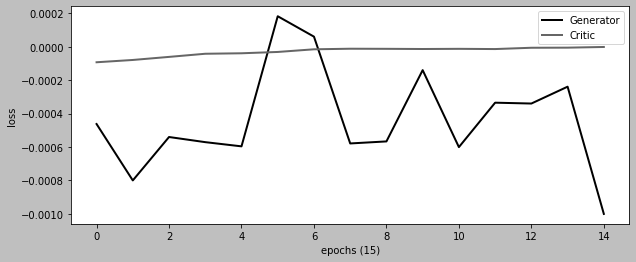

In [ ]:
print('-------------------------------')
print('Training GAN for Normal traffic')
print('-------------------------------')
epochs = 15
normal_generator,l1, l2 = train_gan(pt_train=normal_dataset, data_dim=41, z_dim=100, epochs=epochs, lr=5e-5, critic_iter=5, weight_clip=0.01)
visualize_train_loss(l1, labels=['Generator', 'Critic'], epochs=epochs, loss_2 = l2)

**Generating Data**

In [ ]:
r2l_generated = generate_data(generator=r2l_generator, num_instances=20000, z_dim=100)
u2r_generated = generate_data(generator=u2r_generator, num_instances=20000, z_dim=100)
dos_generated = generate_data(generator=dos_generator, num_instances=20000, z_dim=100)
probe_generated = generate_data(generator=probe_generator, num_instances=20000, z_dim=100)
normal_generated = generate_data(generator=normal_generator, num_instances=20000, z_dim=100)

**Comparison Between Generated and Original Data**

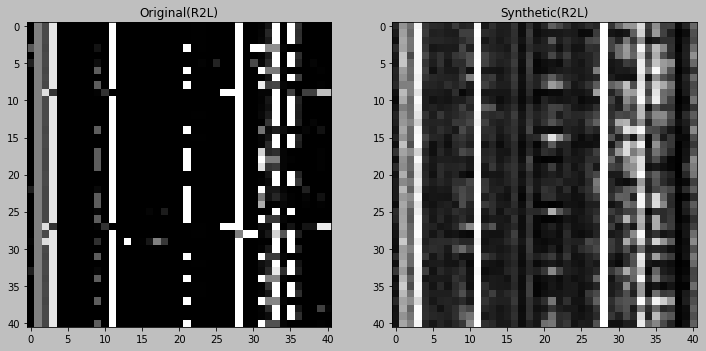

In [ ]:
visualize_synthetic_data(r2l_generated, r2l_attacks, title='R2L')

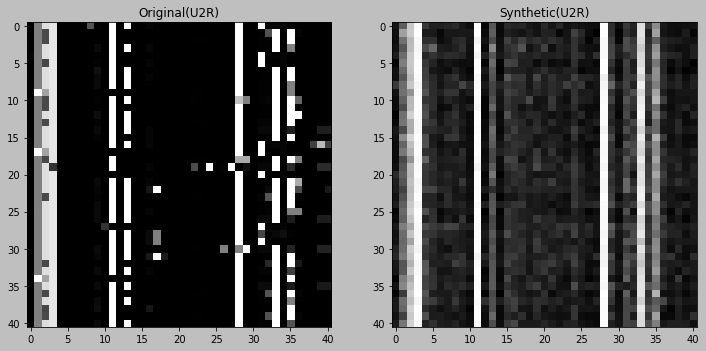

In [ ]:
visualize_synthetic_data(u2r_generated, u2r_attacks.iloc[:,:-1], title='U2R')

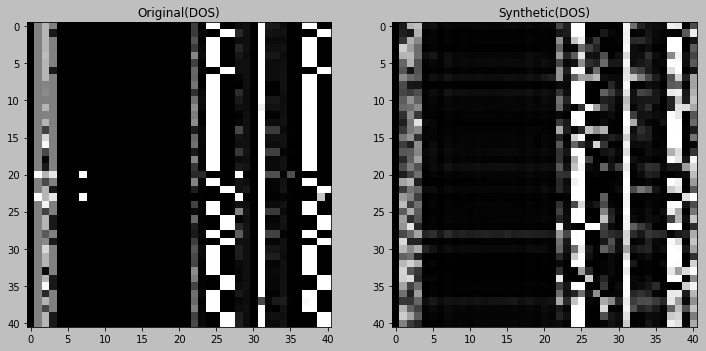

In [ ]:
visualize_synthetic_data(dos_generated, dos_attacks.iloc[:,:-1], title='DOS')

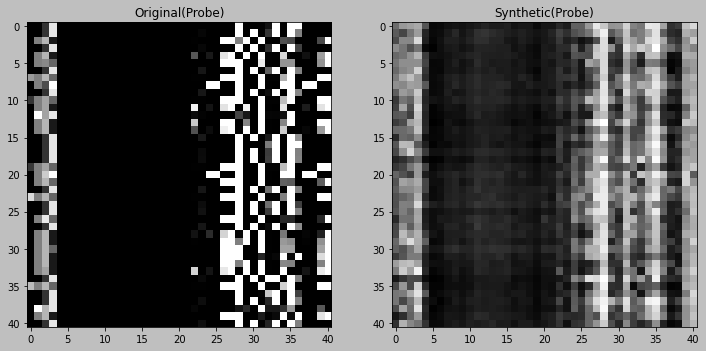

In [ ]:
visualize_synthetic_data(probe_generated, probe_attacks.iloc[:,:-1], title='Probe')

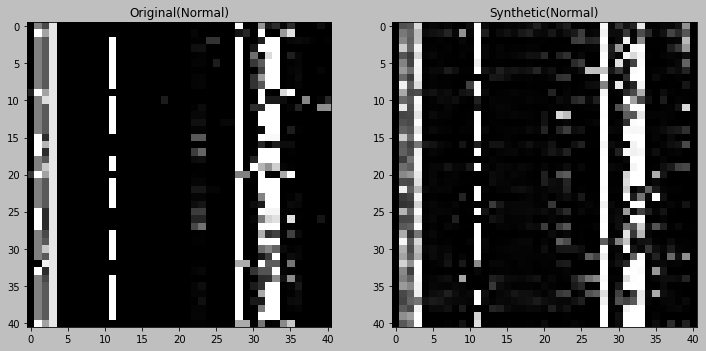

In [ ]:
visualize_synthetic_data(normal_generated, normal_traffic.iloc[:,:-1], title='Normal')

In [ ]:
'''r2l_generated = pd.DataFrame(r2l_generated.numpy())
r2l_generated['label'] = 'r2l'
u2r_generated = pd.DataFrame(u2r_generated.numpy())
u2r_generated['label'] = 'u2r'
dos_generated = pd.DataFrame(dos_generated.numpy())
dos_generated['label'] = 'dos'
probe_generated = pd.DataFrame(probe_generated.numpy())
probe_generated['label'] = 'probe'
normal_generated = pd.DataFrame(normal_generated.numpy())
normal_generated['label'] = 'normal'
'''

"r2l_generated = pd.DataFrame(r2l_generated.numpy())\nr2l_generated['label'] = 'r2l'\nu2r_generated = pd.DataFrame(u2r_generated.numpy())\nu2r_generated['label'] = 'u2r'\ndos_generated = pd.DataFrame(dos_generated.numpy())\ndos_generated['label'] = 'dos'\nprobe_generated = pd.DataFrame(probe_generated.numpy())\nprobe_generated['label'] = 'probe'\nnormal_generated = pd.DataFrame(normal_generated.numpy())\nnormal_generated['label'] = 'normal'\n"

In [ ]:
#dataset = pd.concat([r2l_generated, u2r_generated, dos_generated, probe_generated, normal_generated], axis=0)

In [ ]:
#y = dataset.label
#X = dataset.drop('label', axis = 1)

In [ ]:
#y = y.map(lambda x: 'normal' if x is 'normal'
#               else 'malicious')

In [ ]:
#y = le.fit_transform(y)
#X = normalize_data(X)

In [ ]:
r2l_generated = r2l_generated.numpy()

In [ ]:
u2r_generated = u2r_generated.numpy()

In [ ]:
X = np.concatenate((X_train, r2l_generated))
y = np.append(y_train, np.zeros(shape=(r2l_generated.shape[0],)))

In [ ]:
#X = np.array(X_train)
#y = y_train

In [ ]:
X.shape, y.shape

((145973, 41), (145973,))

In [ ]:
pt_x_train = torch.tensor(X, dtype=torch.float).to(device)
pt_y_train = torch.tensor(y, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)
pt_train = TensorDataset(pt_x_train, pt_y_train)
pt_train = DataLoader(pt_train, batch_size=64, shuffle=False, drop_last=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


AssertionError: ignored

In [ ]:
pt_x_train.shape, pt_y_train.shape

(torch.Size([145973, 41]), torch.Size([64]))

## **CNN Wing 1**



In [ ]:
class CNN1(nn.Module):
  data_dim = 41
  def __init__(self):
      super(CNN1, self).__init__()
      self.mlp = nn.Sequential(
          nn.Linear(self.data_dim, 80),
          nn.ReLU(),
          nn.BatchNorm1d(80)
      )
      '''self.cnn = nn.Sequential(
          nn.Conv1d(1,10,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(10),
          nn.Conv1d(10,10,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(10),
          nn.Conv1d(10,10,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(10),
          nn.Conv1d(10,10,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(10),
          nn.Flatten(),
          nn.Linear(330, 24),
          nn.ReLU(),
      )'''

      self.clf = nn.Sequential(
          nn.Linear(80,1),
          nn.Sigmoid()
      )

  def forward(self, x):
      features = self.mlp(x)
      return self.clf(features)

  def transform(self, x):
      return self.cnn(x)

In [ ]:
mlp = CNN1().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(mlp.parameters(), lr = 1e-1)

In [ ]:
num_epochs = 50
outputs = []
losses = []
for epoch in range(num_epochs):
    for instance, y in pt_train:
        #output = cnn(instance.view(-1,1,1,41))
        output = mlp(instance)
        loss = criterion(output, y.view(-1,1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')

Epoch:1, Loss:0.0001
Epoch:2, Loss:0.0001
Epoch:3, Loss:0.0001
Epoch:4, Loss:0.0001
Epoch:5, Loss:0.0001
Epoch:6, Loss:0.0001
Epoch:7, Loss:0.0001
Epoch:8, Loss:0.0001
Epoch:9, Loss:0.0001
Epoch:10, Loss:0.0001
Epoch:11, Loss:0.0001
Epoch:12, Loss:0.0001
Epoch:13, Loss:0.0001
Epoch:14, Loss:0.0001
Epoch:15, Loss:0.0001
Epoch:16, Loss:0.0001
Epoch:17, Loss:0.0001
Epoch:18, Loss:0.0001
Epoch:19, Loss:0.0001
Epoch:20, Loss:0.0001
Epoch:21, Loss:0.0001
Epoch:22, Loss:0.0001
Epoch:23, Loss:0.0001
Epoch:24, Loss:0.0001
Epoch:25, Loss:0.0001
Epoch:26, Loss:0.0001
Epoch:27, Loss:0.0000
Epoch:28, Loss:0.0000
Epoch:29, Loss:0.0000
Epoch:30, Loss:0.0000
Epoch:31, Loss:0.0000
Epoch:32, Loss:0.0000
Epoch:33, Loss:0.0000
Epoch:34, Loss:0.0000
Epoch:35, Loss:0.0000
Epoch:36, Loss:0.0000
Epoch:37, Loss:0.0000
Epoch:38, Loss:0.0000
Epoch:39, Loss:0.0000
Epoch:40, Loss:0.0000
Epoch:41, Loss:0.0000
Epoch:42, Loss:0.0000
Epoch:43, Loss:0.0000
Epoch:44, Loss:0.0000
Epoch:45, Loss:0.0000
Epoch:46, Loss:0.00

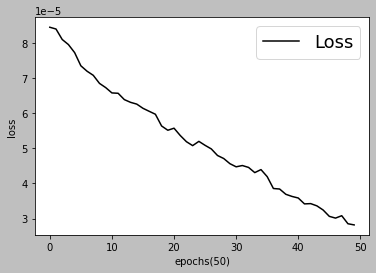

In [ ]:
plt.plot(losses)
plt.xlabel(f"epochs({num_epochs})")
plt.ylabel(f"loss")
_ = plt.legend(['Loss'])

In [ ]:
mlp.eval()
with torch.no_grad():
  #lr_probs = cnn(X_test.view(-1,1,1,41)).detach().squeeze()
  lr_probs = mlp(X_test).detach().squeeze()

In [ ]:
preds = torch.round(lr_probs)

In [ ]:
cm = confusion_matrix(y_test, preds)
tn=cm[1][1] #tn
fn=cm[0][1] #fn
fp=cm[1][0] #fp
tp=cm[0][0] #tp
acc= (tp+tn)/(tp+tn+fn+fp)
epsilon = 1e-7 # is used so that to avoid divide by zero error
precision = tp / (tp + fp + epsilon)
recall = tp / (tp + fn + epsilon)
sensitivity,specificity = tp/(tp+fn),tn/(tn+fp)
print("Test accuracy is:"+str(format(acc,'.4f')))
print("Precision: "+str(format(precision,'.4f'))+"\nRecall: "+str(format(recall,'.4f')))

Test accuracy is:0.8410
Precision: 0.9493
Recall: 0.7613


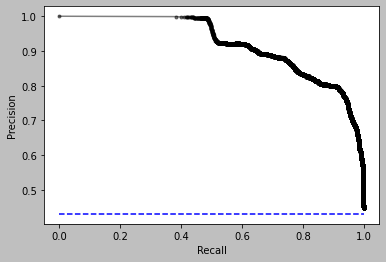

F1:	 83.677%
AUC:	 92.143%
Accuracy:84.098%


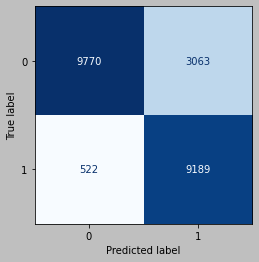

In [ ]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, preds), auc(lr_recall, lr_precision)
no_skill = len(y_test[y_test==1]) / len(y_test)
acc = accuracy_score(y_test, preds)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', c = "blue")
plt.plot(lr_recall, lr_precision, marker='.', alpha=0.5)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')

# show the plot
plt.show()
_ = plt.rc('legend', fontsize=18)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = le.classes_)
disp.plot(cmap="Blues", colorbar = False)
print(f"F1:\t {lr_f1*100:.3f}%")
print(f"AUC:\t {lr_auc*100:.3f}%")
print(f"Accuracy:{acc*100:.3f}%")

In [ ]:
torch.save(mlp.state_dict(), 'mlp.pt')